## Regime diagram

This notebook plots regime diagrams in parameter spaces La$_t$ - $h/L_L$ following [Belcher et al, 2012](https://doi.org/10.1029/2012GL052932) and the extension to stable surface forcing regime.

In particular, parameter space covered by JRA55-do forced GOTM runs, GOTM runs at OSMOSIS site (winter and spring) and OCS-Papa(full year) and some previous LES studies of Langmuir turbulence.

### Load modules 

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools')
from gotmanalysis import GOTMOutputData, GOTMOutputDataMap, \
                         plot_regime_diagram_background_BG12, \
                         plot_regime_diagram_background_L19, \
                         plot_dist_4p, plot_dist_3p
np.seterr(all='raise')
%matplotlib inline

### Functions

In [2]:
def filter_hLL(laturb, hLL, condition='Destabilizing'):
    xdata = np.copy(laturb)
    ydata = np.copy(hLL)
    if condition == 'Destabilizing':
        # remove data points where h/L_L<0 
        inds = ydata < 0
    elif condition == 'Stabilizing':
        # remove data points where h/L_L>0
        inds = ydata > 0
    else:
        raise ValueError('Condition {} not supported. Should be \'Destabilizing\' or \'Stabilizing\'')
    ncon = np.sum(inds) 
    print(condition+' h/L_L: {:6.2f}%'.format(100-ncon/ydata.size*100))
    xdata[inds] = np.nan
    ydata[inds] = np.nan
    xdata = xdata[~np.isnan(xdata)]
    ydata = ydata[~np.isnan(ydata)]
    return xdata, ydata

In [3]:
def loglog_hist2d(xdata, ydata, xpr, ypr):
    hist, xi, yi, c = plt.hist2d(xdata, ydata, range=(xpr, ypr), bins=100)
    # clean the figure
    plt.clf()
    # get the centers from the edges
    xi = 0.5*(xi[0:-1]+xi[1:])
    yi = 0.5*(yi[0:-1]+yi[1:])
    # convert back to actual values
    xi = 10**xi
    yi = 10**yi
    return hist, xi, yi

In [4]:
def plot_regime_diagram_BG12(hist, xi, yi, axis=None):
    """Plot regime diagram following Belcher et al., 2012
    
    """
    # background following Fig. 3 of Belcher et al., 2012
    plot_regime_diagram_background_BG12(axis=axis)
    
    # plot bi-dimensional histogram
    plot_dist_4p(hist, xi, yi, axis=axis, colors='white', linestyles='-')


In [5]:
def plot_regime_diagram_heating(hist, xi, yi, axis=None):
    if axis is None:
        axis = plt.gca()
        
    # plot bi-dimensional histogram
    plot_dist_4p(hist, xi, yi, axis=axis, colors='black', linestyles='-')
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel('La$_t$')
    axis.set_ylabel('$-h/L_L$')
    axis.set_aspect(aspect=1/3)
    axis.text(0.11, 4e-3, 'Langmuir', bbox=dict(boxstyle="square",ec='k',fc='w'))
    axis.text(3, 4e-3, 'Wind', bbox=dict(boxstyle="square",ec='k',fc='w'))
    axis.text(0.13, 1e2, 'Stable', bbox=dict(boxstyle="square",ec='k',fc='w'))

In [6]:
def plot_forcing_regime(hist, xi, yi, axis=None):
    """Plot diagram of forcing regime
    
    """
    # background
    plot_regime_diagram_background_L19()

    # plot bi-dimensional histogram
    plot_dist_4p(hist, xi, yi, axis=axis, colors='white', linestyles='-')

In [7]:
def add_scatter(la, hLL, axis=None, pmode='les', **kwargs):
    if axis is None:
        axis = plt.gca()
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    if pmode == 'les':
        xx = np.where(la<xlims[0], xlims[0], la)
        xx = np.where(xx>xlims[1], xlims[1], xx)
        yy = np.where(hLL<ylims[0], ylims[0], hLL)
        yy = np.where(yy>ylims[1], ylims[1], yy)
        axis.scatter(xx, yy, s=12, clip_on=False, zorder=10, **kwargs)
    elif pmode == 'jra55-do':
        xx = np.where(la<xlims[0], xlims[0]*0.1, la)
        xx = np.where(xx>xlims[1], xlims[1]*10, xx)
        yy = np.where(hLL<ylims[0], ylims[0]*0.1, hLL)
        yy = np.where(yy>ylims[1], ylims[1]*10, yy)
        axis.scatter(xx, yy, s=1, clip_on=True, zorder=4, **kwargs)
    else:
        raise ValueError('Value of pmode {} not supported. Supported: les, jra55-do'
                         .format(pmode))

In [8]:
def add_range(xrange, yrange, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    xrange = np.maximum(xlims[0], xrange)
    xrange = np.minimum(xlims[1], xrange)
    yrange = np.maximum(ylims[0], yrange)
    yrange = np.minimum(ylims[1], yrange)
    axis.plot(xrange, yrange, '--', linewidth=2.5, clip_on=False, zorder=9, **kwargs)

In [9]:
def add_mean_and_range(xm, xmin, xmax, ym, ymin, ymax, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    xm = np.maximum(xlims[0], xm)
    xm = np.minimum(xlims[1], xm)
    xmin = np.maximum(xlims[0], xmin)
    xmin = np.minimum(xlims[1], xmin)
    xmax = np.maximum(xlims[0], xmax)
    xmax = np.minimum(xlims[1], xmax)
    ym = np.maximum(ylims[0], ym)
    ym = np.minimum(ylims[1], ym)
    ymin = np.maximum(ylims[0], ymin)
    ymin = np.minimum(ylims[1], ymin)
    ymax = np.maximum(ylims[0], ymax)
    ymax = np.minimum(ylims[1], ymax)
    axis.scatter(xm, ym, s=13, marker='d', clip_on=False, zorder=10, **kwargs)
    ndim = xm.size
    for i in np.arange(ndim):
        axis.plot([xmin[i], xmax[i]], [ym[i], ym[i]], linewidth=1.3,
                  clip_on=False, zorder=10, **kwargs)
        axis.plot([xm[i], xm[i]], [ymin[i], ymax[i]], linewidth=1.3,
                  clip_on=False, zorder=10, **kwargs)

In [10]:
def add_legend(axis, xloc, yloc, color, text):
    axis.scatter(xloc, yloc, s=16, color=color, transform=axis.transAxes)
    axis.text(xloc+0.015, yloc, text, fontsize=9,
              transform=axis.transAxes, color='k',
              va='center')

### $h/L_L$ and La$_t$ in previous LES studies

In [11]:
# McWilliams et al., 1997
c_msm97 = 'navy'
msm97_la = np.array([0.3, 1000])
msm97_ustar = np.ones(msm97_la.size)*6.1e-3
msm97_B0 = np.ones(msm97_la.size)*5/4200/1000*2e-4*9.8
msm97_mld = np.ones(msm97_la.size)*35
msm97_hLL = msm97_la**2*msm97_B0*msm97_mld/msm97_ustar**3

In [12]:
# Li et al., 2005
# h/LL = Ho * \beta * H / 4
c_l05 = 'skyblue'
l05_la_range_s1 = [0.2, 10]
l05_hLL_s1 = 0.0
l05_la_s2 = 0.34
l05_hLL_range_s2 = [0, 100]
# surface heating cases
l05_ho_s3 = np.array([0.25, 0.45])
l05_hiLL_s3 = l05_ho_s3*8.4/4
l05_hLL_s3 = l05_hiLL_s3/(1+3.*l05_hiLL_s3) 
l05_la_s3 = np.ones(l05_hLL_s3.size)*0.34

In [13]:
# Harcourt and D'Asaro 2008
c_hd08 = 'orange'
hd08_la_s1 = np.array([0.331, 0.341, 0.351, 0.360, 0.366, 0.375, 0.381, 0.387,
                       0.306, 0.316, 0.325, 0.332, 0.338, 0.346, 0.351, 0.357,
                       0.291, 0.301, 0.309, 0.316, 0.322, 0.329, 0.333, 0.339,
                       0.270, 0.278, 0.286, 0.292, 0.298, 0.304, 0.308, 0.313])
hd08_la_s2 = np.array([0.275, 0.288, 0.300, 0.310, 0.320, 0.331, 0.339, 0.347])
hd08_la_s3 = np.array([0.404, 0.417, 0.435, 0.364, 0.364, 0.364, 0.364])
hd08_la_s4 = np.array([0.270, 0.278, 0.286, 0.292, 0.298, 0.304, 0.308, 0.313])
hd08_hLL_s1 = np.ones(hd08_la_s1.size)*1e-8
hd08_hLL_s2 = np.ones(hd08_la_s2.size)*1e-8
hd08_hLL_s3 = np.ones(hd08_la_s3.size)*1e-8
hd08_hLL_s4 = np.ones(hd08_la_s4.size)*1e-8

In [14]:
# Grant and Belcher, 2009
c_gb09 = 'royalblue'
gb09_la = np.array([0.15, 0.2, 0.3, 0.4, 0.8, 1.5])
gb09_hLL = np.ones(gb09_la.size)*1e-8

In [15]:
# Van Roekel et al., 2012
c_vr12 = 'orchid'
vr12_la = np.array([0.18, 0.23, 0.29, 0.37, 0.49])
vr12_us0 = np.array([0.022, 0.038, 0.063, 0.100, 0.162])
vr12_ustar = np.ones(vr12_la.size)*5.3e-3
vr12_mld = np.ones(vr12_la.size)*35
vr12_B0 = np.ones(vr12_la.size)*5/4200/1000*2e-4*9.8
vr12_hLL = vr12_la**2*vr12_B0*vr12_mld/vr12_ustar**3

In [16]:
# Pearson et al., 2015 (surface heating)
c_p15 = 'firebrick'
p15_LL_s1 = np.array([62, 93, 124, 186, 248, 372, 496])
p15_hi_s1 = 53
p15_hiLL_s1 = p15_hi_s1/p15_LL_s1
p15_hLL_s1 = p15_hiLL_s1/(1+3.5*p15_hiLL_s1)
p15_la_s1 = np.ones(p15_LL_s1.size)*0.3
p15_LL_s2 = np.array([93, 124, 186, 248, 372])
p15_hi_s2 = 36
p15_hiLL_s2 = p15_hi_s2/p15_LL_s2
p15_hLL_s2 = p15_hiLL_s2/(1+3.*p15_hiLL_s2)
p15_la_s2 = np.ones(p15_LL_s2.size)*0.3

In [17]:
# Min and Noh, 2004 (surface heating)
c_mn04 = 'green'
mn04_ustar_i = np.array([0.01, 0.01, 0.01, 0.01, 0.005, 0.01, 0.01])
mn04_us0_i = np.array([0.082, 0.082, 0.195, 0.05, 0.082, 0.082, 0.082])
mn04_la_i = np.array([0.35, 0.35, 0.23, 0.45, 0.25, 0.35, 0.35])
mn04_hi = 50
mn04_B0_j = np.array([1, 2, 4, 6, 8, 10])*1e-7
mn04_ni = mn04_ustar_i.size
mn04_nj = mn04_B0_j.size
mn04_la_arr = np.zeros([mn04_ni, mn04_nj])
mn04_hiLL_arr = np.zeros([mn04_ni, mn04_nj])
for j in np.arange(mn04_nj):
    mn04_la_arr[:,j] = mn04_la_i
    mn04_hiLL_arr[:,j] = mn04_la_i[:]**2 / mn04_ustar_i[:]**3 * mn04_B0_j[j] * mn04_hi
mn04_la = mn04_la_arr.flatten()
mn04_hiLL = mn04_hiLL_arr.flatten()
mn04_hLL = mn04_hiLL/(1+3.*mn04_hiLL)

In [18]:
# Reichl et al., 2016
c_r16 = 'mediumpurple'
r16_data_s1 = sio.loadmat(os.environ['GOTMFIG_ROOT']+ \
                          '/data/R16/RWHGK16_log10_ParamSpace_5.mat')
r16_data_s2 = sio.loadmat(os.environ['GOTMFIG_ROOT']+ \
                          '/data/R16/RWHGK16_log10_ParamSpace_10.mat')
r16_la_s1_mean = r16_data_s1['LAt_mean'].flatten()
r16_la_s1_std = r16_data_s1['LAt_std'].flatten()
r16_la_s2_mean = r16_data_s2['LAt_mean'].flatten()
r16_la_s2_std = r16_data_s2['LAt_std'].flatten()
r16_hLL_s1_mean = r16_data_s1['H_LL_mean'].flatten() 
r16_hLL_s1_std = r16_data_s1['H_LL_std'].flatten() 
r16_hLL_s2_mean = r16_data_s2['H_LL_mean'].flatten() 
r16_hLL_s2_std = r16_data_s2['H_LL_std'].flatten()

In [19]:
# Li and Fox-Kemper, 2017
c_lf17 = 'pink'
lf17_data = sio.loadmat(os.environ['GOTMFIG_ROOT']+'/data/LF17/LF17_La_hLL.mat')
lf17_la_tmp = lf17_data['la']
lf17_la_tmp = np.where(np.isinf(lf17_la_tmp), np.nan, lf17_la_tmp)
lf17_la = lf17_la_tmp[~np.isnan(lf17_la_tmp)]
lf17_hLL_tmp = lf17_data['hL']
lf17_hLL_tmp = np.where(np.isinf(lf17_hLL_tmp), np.nan, lf17_hLL_tmp)
lf17_hLL = lf17_hLL_tmp[~np.isnan(lf17_la_tmp)]

### $h/L_L$ and La$_t$ in JRA55-do

In [20]:
# JRA55-do forcing data

# update data if True
update_data = False

# case name
casename = 'JRA55-do_Global_dampV5d_3h_r4'
tmname = 'KPP-CVMix'
# lists
timetag_list = ['20090101-20090131',
                '20090201-20090228',
                '20090301-20090331',
                '20090401-20090430',
                '20090501-20090531',
                '20080601-20080630',
                '20080701-20080731',
                '20080801-20080831',
                '20080901-20080930',
                '20081001-20081031',
                '20081101-20081130',
                '20081201-20081231']
ntag = len(timetag_list)

# read data
mon_lat = []
mon_lon = []
mon_time = []
mon_laturb = []
mon_bflux = []
mon_bflux_rad = []
mon_ustar = []
mon_hbl = []
mon_hbl_kpp = []
for j in np.arange(ntag):
    timetag = timetag_list[j]
    # read surface forcing  data
    s1data_root = os.environ['GOTMRUN_ROOT']+'/'+casename+'/VR1m_DT600s_'+timetag
    s2data_root = os.environ['GOTMFIG_ROOT']+'/data/'+casename+'/VR1m_DT600s_'+timetag
    os.makedirs(s2data_root, exist_ok=True)
    basepath = s1data_root+'/'+tmname
    s2data_name = s2data_root+'/data_mapts_surface_forcing_'+tmname+'.npz'
    if update_data or not os.path.isfile(s2data_name):
        # update data
        print('Updating data for {} ...'.format(timetag))
        loclist = sorted(os.listdir(basepath))
        pathlist = [basepath+'/'+x+'/gotm_out_s1.nc' for x in loclist]
        godmobj = GOTMOutputDataMap(pathlist)
        laturb = np.zeros([godmobj.ncase, godmobj.ntime-1])
        bflux = np.zeros([godmobj.ncase, godmobj.ntime-1])
        bflux_rad = np.zeros([godmobj.ncase, godmobj.ntime-1])
        ustar = np.zeros([godmobj.ncase, godmobj.ntime-1])
        hbl = np.zeros([godmobj.ncase, godmobj.ntime-1])
        hbl_kpp = np.zeros([godmobj.ncase, godmobj.ntime-1])
        lat = godmobj.lat
        lon = godmobj.lon
        time = godmobj.time[1:]
        for i in np.arange(godmobj.ncase):
            if np.mod(i, 100) == 0:
                print('{:6.2f} %'.format(i/godmobj.ncase*100.0))
            tmp = GOTMOutputData(godmobj._paths[i], init_time_location=False)
            laturb[i,:] = tmp.read_timeseries('LaTurb', ignore_time=True).data[1:]
            bflux[i,:] = tmp.read_timeseries('bflux', ignore_time=True).data[1:]
            bflux_rad[i,:] = tmp.read_timeseries('bflux', ignore_time=True, radiative_heating=True).data[1:]
            ustar[i,:] = tmp.read_timeseries('u_taus', ignore_time=True).data[1:]
            hbl[i,:] = tmp.read_timeseries('bld_nuh', ignore_time=True).data[1:]
            try:
                hbl_kpp[i,:] = tmp.read_timeseries('bld_kpp', ignore_time=True).data[1:]
            except:
                pass
        # save data
        np.savez(s2data_name, laturb=laturb, bflux=bflux, bflux_rad=bflux_rad, ustar=ustar, hbl=hbl,
                 hbl_kpp=hbl_kpp, lon=lon, lat=lat, time=time)
    else:
        # read data
        tmp = np.load(s2data_name)
        lat = tmp['lat']
        lon = tmp['lon']
        time = tmp['time']
        laturb = tmp['laturb']
        bflux = tmp['bflux']
        bflux_rad = tmp['bflux_rad']
        ustar = tmp['ustar']
        hbl = tmp['hbl']
        try:
            hbl_kpp = tmp['hbl_kpp']
        except:
            print('hbl_kpp not applicable, set to hbl')
            hbl_kpp = hbl
    # append to monthly lists
    mon_lat.append(lat)
    mon_lon.append(lon)
    mon_time.append(time)
    mon_laturb.append(laturb)
    mon_bflux.append(bflux)
    mon_bflux_rad.append(bflux_rad)
    mon_ustar.append(ustar)
    mon_hbl.append(hbl)
    mon_hbl_kpp.append(hbl_kpp)
    
# paths for figures
fig_root = os.environ['GOTMFIG_ROOT']+'/'+casename+'/regime_diagram/'+tmname
os.makedirs(fig_root, exist_ok=True)

# concatenate data

# turbulent Langmuir number
fld_laturb = np.concatenate([mon_laturb[i].flatten() for i in np.arange(ntag)])
# surface buoyancy flux
fld_bflux = np.concatenate([mon_bflux[i].flatten() for i in np.arange(ntag)])
fld_bflux_rad = np.concatenate([mon_bflux_rad[i].flatten() for i in np.arange(ntag)])
# friction velocity
fld_ustar = np.concatenate([mon_ustar[i].flatten() for i in np.arange(ntag)])
# boundary layer depth
fld_hbl = np.concatenate([mon_hbl[i].flatten() for i in np.arange(ntag)])
fld_hbl_kpp = np.concatenate([mon_hbl_kpp[i].flatten() for i in np.arange(ntag)])
# remove data points where friction velocity is zero
inds = fld_ustar==0
print('Invalid data points: {:6.2f}%'.format(np.sum(inds)/fld_ustar.size*100))
fld_laturb[inds] = np.nan
fld_bflux[inds] = np.nan
fld_bflux_rad[inds] = np.nan
fld_ustar[inds] = np.nan
fld_hbl[inds] = np.nan
fld_hbl_kpp[inds] = np.nan
fld_laturb = fld_laturb[~np.isnan(fld_laturb)]
fld_bflux = fld_bflux[~np.isnan(fld_bflux)]
fld_bflux_rad = fld_bflux_rad[~np.isnan(fld_bflux_rad)]
fld_ustar = fld_ustar[~np.isnan(fld_ustar)]
fld_hbl = fld_hbl[~np.isnan(fld_hbl)]
fld_hbl_kpp = fld_hbl_kpp[~np.isnan(fld_hbl_kpp)]
print('Total number of valid data points: {:6d}'.format(len(fld_laturb)))

Invalid data points:   0.12%
Total number of valid data points: 5700493


In [21]:
# Distribution in log10(h/L_L) and log10(La_t) space

# h_b/L_L
# fld_hLL = -fld_bflux*fld_hbl/(fld_ustar**3)*fld_laturb**2
fld_hLL = -fld_bflux*fld_hbl_kpp/(fld_ustar**3)*fld_laturb**2

# Surface cooling
fld_laturb_s1, fld_hLL_s1 = filter_hLL(fld_laturb, fld_hLL, 'Destabilizing')

# get the bi-dimensional histogram in log-log space
xdata = np.log10(fld_laturb_s1)
ydata = np.log10(fld_hLL_s1)
hist_s1, xi_s1, yi_s1 = loglog_hist2d(xdata, ydata, xpr=[-1, 1], ypr=[-3, 3])

# --------

# Surface heating
fld_laturb_s2, fld_hLL_s2 = filter_hLL(fld_laturb, fld_hLL, 'Stabilizing')

# get the bi-dimensional histogram in log-log space
xdata = np.log10(fld_laturb_s2)
ydata = np.log10(-fld_hLL_s2)
hist_s2, xi_s2, yi_s2 = loglog_hist2d(xdata, ydata, xpr=[-1, 1], ypr=[-3, 3])

Destabilizing h/L_L:  62.31%
Stabilizing h/L_L:  37.69%


<Figure size 432x288 with 0 Axes>

In [22]:
# Distribution in h/L_L and La_t space

xdata = np.copy(fld_laturb)
ydata = np.copy(fld_hLL)

# range 
xpr = [0.1, 10]
ypr = [-1e3, 1e3]
hist, xi, yi, c = plt.hist2d(xdata, ydata, range=(xpr,ypr), bins=[500,20000])
# clean the figure
plt.clf()
# get the centers from the edges
xi = 0.5*(xi[0:-1]+xi[1:])
yi = 0.5*(yi[0:-1]+yi[1:])

<Figure size 432x288 with 0 Axes>

### Figures

Test for plotting background of the regime diagrams.

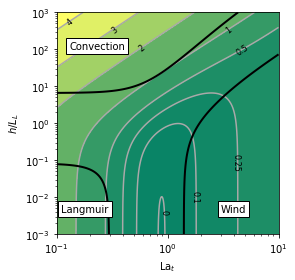

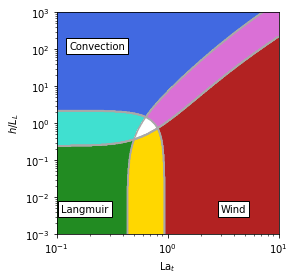

In [23]:
# Figure tests

# plot figure a
fig = plt.figure()
fig.set_size_inches(4.5, 4)

# plot only the background of regime diagram
plot_regime_diagram_background_BG12()

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/fig_regime_diagram_BG12_background.png'
plt.savefig(figname, dpi = 300)

# --------

# plot figure b
fig = plt.figure()
fig.set_size_inches(4.5, 4)

# plot only the background of regime diagram
plot_regime_diagram_background_L19()

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/fig_regime_diagram_L19_background.png'
plt.savefig(figname, dpi = 300)

# --------

### Figure 1: regime diagram following Belcher et al., 2012 

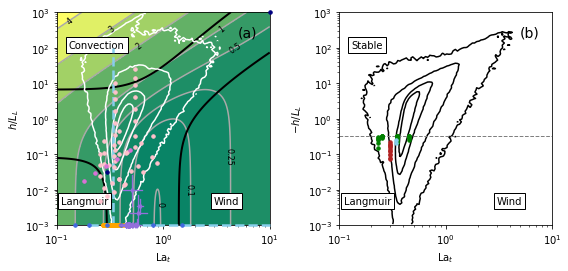

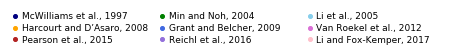

In [24]:
# Figure 1: regime diagram following Belcher et al., 2012

fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

# plot regime diagram with pdf overlaid
plot_regime_diagram_BG12(hist_s1, xi_s1, yi_s1, axis=axarr[0])
    
axarr[0].text(5, 2e2, '(a)', fontsize=14, color='black')

# plot bi-dimensional histogram
plot_regime_diagram_heating(hist_s2, xi_s2, yi_s2, axis=axarr[1])
axarr[1].text(5, 2e2, '(b)', fontsize=14, color='black')

# y-shift of legend
yshift = -0.13

# Li and Fox-Kemper, 2017
add_scatter(lf17_la, lf17_hLL, color=c_lf17, axis=axarr[0])
# axarr[1].text(0.75, 0.35+yshift, 'LF17', transform=axarr[1].transAxes,
#               color=c_lf17, fontweight='bold')

# McWilliams et al., 1997
add_scatter(msm97_la, msm97_hLL, color=c_msm97, axis=axarr[0])
# axarr[1].text(0.75, 0.75+yshift, 'MSM97', transform=axarr[1].transAxes,
#               color=c_msm97, fontweight='bold')

# Min and Noh, 2004
add_scatter(mn04_la, mn04_hLL, color=c_mn04, axis=axarr[1]) # heating
# axarr[1].text(0.75, 0.7+yshift, 'MN04', transform=axarr[1].transAxes,
#               color=c_mn04, fontweight='bold')

# Li et al., 2005
add_range(l05_la_range_s1, [l05_hLL_s1, l05_hLL_s1], color=c_l05, axis=axarr[0])
add_range([l05_la_s2, l05_la_s2], l05_hLL_range_s2, color=c_l05, axis=axarr[0])
add_scatter(l05_la_s3, l05_hLL_s3, color=c_l05, axis=axarr[1])
# axarr[1].text(0.75, 0.65+yshift, 'L05', transform=axarr[1].transAxes,
#               color=c_l05, fontweight='bold')

# Harcourt and D'Asaro, 2008
add_scatter(hd08_la_s1, hd08_hLL_s1, color=c_hd08, axis=axarr[0])
add_scatter(hd08_la_s2, hd08_hLL_s2, color=c_hd08, axis=axarr[0])
add_scatter(hd08_la_s3, hd08_hLL_s3, color=c_hd08, axis=axarr[0])
add_scatter(hd08_la_s4, hd08_hLL_s4, color=c_hd08, axis=axarr[0])
# axarr[1].text(0.75, 0.6+yshift, 'HD08', transform=axarr[1].transAxes,
#               color=c_hd08, fontweight='bold')

# Grant and Belcher, 2009
add_scatter(gb09_la, gb09_hLL, color=c_gb09, axis=axarr[0])
# axarr[1].text(0.75, 0.55+yshift, 'GB09', transform=axarr[1].transAxes,
#               color=c_gb09, fontweight='bold')

# Van Roekel et al., 2012
add_scatter(vr12_la, vr12_hLL, color=c_vr12, axis=axarr[0])
# axarr[1].text(0.75, 0.5+yshift, 'VR12', transform=axarr[1].transAxes,
#               color=c_vr12, fontweight='bold')

# Pearson et al., 2015
add_scatter(p15_la_s1, p15_hLL_s1, color=c_p15, axis=axarr[1]) # heating
add_scatter(p15_la_s2, p15_hLL_s2, color=c_p15, axis=axarr[1]) # heating
# axarr[1].text(0.75, 0.45+yshift, 'P15', transform=axarr[1].transAxes,
#               color=c_p15, fontweight='bold')

# Reichl et al., 2016
r16_la_s1_m = 10**r16_la_s1_mean
r16_la_s1_min = 10**(r16_la_s1_mean-r16_la_s1_std)
r16_la_s1_max = 10**(r16_la_s1_mean+r16_la_s1_std)
r16_hLL_s1_m = 10**r16_hLL_s1_mean
r16_hLL_s1_min = 10**(r16_hLL_s1_mean-r16_hLL_s1_std)
r16_hLL_s1_max = 10**(r16_hLL_s1_mean+r16_hLL_s1_std)
add_mean_and_range(r16_la_s1_m, r16_la_s1_min, r16_la_s1_max,
                   r16_hLL_s1_m, r16_hLL_s1_min, r16_hLL_s1_max,
                   color=c_r16, axis=axarr[0])
r16_la_s2_m = 10**r16_la_s2_mean
r16_la_s2_min = 10**(r16_la_s2_mean-r16_la_s2_std)
r16_la_s2_max = 10**(r16_la_s2_mean+r16_la_s2_std)
r16_hLL_s2_m = 10**r16_hLL_s2_mean
r16_hLL_s2_min = 10**(r16_hLL_s2_mean-r16_hLL_s2_std)
r16_hLL_s2_max = 10**(r16_hLL_s2_mean+r16_hLL_s2_std)
add_mean_and_range(r16_la_s2_m, r16_la_s2_min, r16_la_s2_max,
                   r16_hLL_s2_m, r16_hLL_s2_min, r16_hLL_s2_max,
                   color=c_r16, axis=axarr[0])
# axarr[1].text(0.75, 0.4+yshift, 'R16', transform=axarr[1].transAxes, color=c_r16,
#               fontweight='bold')

axarr[1].plot([1e-1, 1e1], [1/3, 1/3], '--', color='gray', linewidth=1)

# reduce margin
plt.tight_layout()
plt.subplots_adjust(bottom=0.06)

# save figure
figname = fig_root+'/fig_regime_diagram_BG12_sct.png'
plt.savefig(figname, dpi = 300)

# plot legend
fig = plt.figure()
fig.set_size_inches(8, 0.65)
# x- and y-labels
ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
x_c1 = 0.01
x_c2 = 0.34
x_c3 = 0.67
y_r1 = 0.83
y_r2 = 0.5
y_r3 = 0.17
add_legend(ax, x_c1, y_r1, c_msm97, 'McWilliams et al., 1997')
add_legend(ax, x_c2, y_r1, c_mn04,  'Min and Noh, 2004')
add_legend(ax, x_c3, y_r1, c_l05,   'Li et al., 2005')
add_legend(ax, x_c1, y_r2, c_hd08,  'Harcourt and D’Asaro, 2008')
add_legend(ax, x_c2, y_r2, c_gb09,  'Grant and Belcher, 2009')
add_legend(ax, x_c3, y_r2, c_vr12,  'Van Roekel et al., 2012')
add_legend(ax, x_c1, y_r3, c_p15,   'Pearson et al., 2015')
add_legend(ax, x_c2, y_r3, c_r16,   'Reichl et al., 2016')
add_legend(ax, x_c3, y_r3, c_lf17,  'Li and Fox-Kemper, 2017')
# save figure
figname = fig_root+'/regime_diagram_legend.png'
plt.savefig(figname, dpi = 300)

### Figure 2: forcing regime 

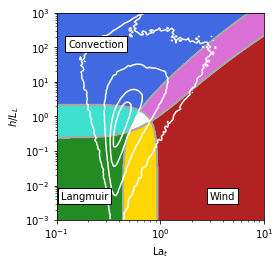

In [25]:
# Figure 2: forcing regime

# plot figure
fig = plt.figure()
fig.set_size_inches(4, 3.8)

plot_forcing_regime(hist_s1, xi_s1, yi_s1)

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/fig_diag_forcing_regime_BG12.png'
plt.savefig(figname, dpi = 300)

### Figure 3: scatter for JRA55-do 

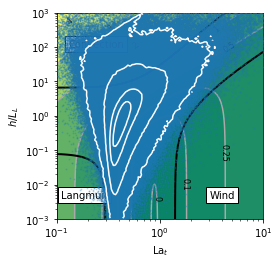

In [26]:
# Figure 3: scatter for JRA55-do

# plot figure
fig = plt.figure()
fig.set_size_inches(4, 3.8)

plot_regime_diagram_background_BG12()

add_scatter(fld_laturb, fld_hLL, pmode='jra55-do', alpha=0.2)

plot_dist_4p(hist_s1, xi_s1, yi_s1, colors='white', linestyles='-', zorder=5)

# save figure
figname = fig_root+'/regime_diagram_scatter_contour.png'
plt.savefig(figname, dpi = 300)

### Figure 4: PDF in linear and log-log spaces 

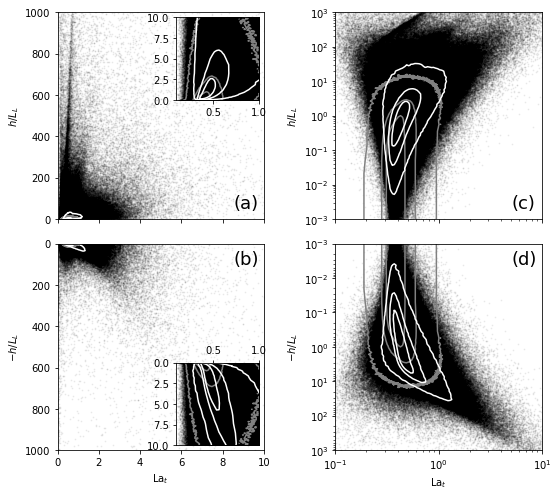

In [27]:
# Figure 4: PDF in linear and log-log spaces

# plot figure
fig, axarr = plt.subplots(2, 2, sharex='col')
fig.set_size_inches(8, 7)

# plot scatters
axarr[0,0].scatter(fld_laturb,  fld_hLL, s=1, c='k', alpha=0.05)
axarr[0,1].scatter(fld_laturb,  fld_hLL, s=1, c='k', alpha=0.05)
axarr[1,0].scatter(fld_laturb, -fld_hLL, s=1, c='k', alpha=0.05)
axarr[1,1].scatter(fld_laturb, -fld_hLL, s=1, c='k', alpha=0.05)

# set axis properties
axarr[0,0].set_xlim([0, 10])
axarr[0,0].set_ylim([0, 1e3])
# axarr[0,0].set_xlabel('La$_t$')
axarr[0,0].set_ylabel('$h/L_L$')
axarr[0,0].set_aspect(aspect=1/100)

axarr[0,1].set_xscale('log')
axarr[0,1].set_yscale('log')
axarr[0,1].set_xlim([10**-1, 10])
axarr[0,1].set_ylim([1e-3, 1e3])
# axarr[0,1].set_xlabel('La$_t$')
axarr[0,1].set_ylabel('$h/L_L$')
axarr[0,1].set_aspect(aspect=1/3)

axarr[1,0].set_xlim([0, 10])
axarr[1,0].set_ylim([1e3, 0])
axarr[1,0].set_xlabel('La$_t$')
axarr[1,0].set_ylabel('$-h/L_L$')
axarr[1,0].set_aspect(aspect=1/100)

axarr[1,1].set_xscale('log')
axarr[1,1].set_yscale('log')
axarr[1,1].set_xlim([10**-1, 10])
axarr[1,1].set_ylim([1e3, 1e-3])
axarr[1,1].set_xlabel('La$_t$')
axarr[1,1].set_ylabel('$-h/L_L$')
axarr[1,1].set_aspect(aspect=1/3)

# pdf in linear space: La_t and h/L_L
# (contours that enclose 30%, 60% and 90% of all instances centered at the highest pdf)
plot_dist_3p(hist, xi, yi, colors='gray', linestyles='-', axis=axarr[0,0])
plot_dist_3p(hist, xi, yi, colors='gray', linestyles='-', axis=axarr[0,1])
plot_dist_3p(hist, xi, yi, colors='gray', linestyles='-', axis=axarr[1,0])
plot_dist_3p(hist, xi, yi, colors='gray', linestyles='-', axis=axarr[1,1])

# pdf in log space: log10(La_t) and log10(h/L_L)
# (contours that enclose 30%, 60% and 90% of all instances centered at the highest pdf)
plot_dist_3p(hist_s1, xi_s1, yi_s1, colors='w', linestyles='-', axis=axarr[0,1])
plot_dist_3p(hist_s2, xi_s2, yi_s2, colors='w', linestyles='-', axis=axarr[1,1])
plot_dist_3p(hist_s1, xi_s1, yi_s1, colors='w', linestyles='-', axis=axarr[0,0])
plot_dist_3p(hist_s2, xi_s2, yi_s2, colors='w', linestyles='-', axis=axarr[1,0])

# reduce margin
plt.tight_layout()

# inset for zoom-in of linear space
ax_inset1 = inset_axes(axarr[0,0], width="40%", height="40%", loc=1)
ax_inset1.scatter(fld_laturb,  fld_hLL, s=1, c='k', alpha=0.05)
plot_dist_3p(hist, xi, yi, colors='gray', linestyles='-', axis=ax_inset1)
plot_dist_3p(hist_s1, xi_s1, yi_s1, colors='w', linestyles='-', axis=ax_inset1)
ax_inset1.set_xlim([10**-1, 1])
ax_inset1.set_ylim([1e-3, 1e1])

ax_inset2 = inset_axes(axarr[1,0], width="40%", height="40%", loc=4)
ax_inset2.scatter(fld_laturb,  fld_hLL, s=1, c='k', alpha=0.05)
plot_dist_3p(hist, xi, yi, colors='gray', linestyles='-', axis=ax_inset2)
plot_dist_3p(hist_s2, xi_s2, yi_s2, colors='w', linestyles='-', axis=ax_inset2)
ax_inset2.invert_yaxis()
ax_inset2.set_xlim([10**-1, 1])
ax_inset2.set_ylim([1e1, 1e-3])
ax_inset2.xaxis.tick_top()
ax_inset2.xaxis.set_label_position('top')

# panel label
axarr[0,0].text(0.85, 0.05, '(a)', fontsize=18, transform=axarr[0,0].transAxes,
                color='black')
axarr[0,1].text(0.85, 0.05, '(c)', fontsize=18, transform=axarr[0,1].transAxes,
                color='black')
axarr[1,0].text(0.85, 0.9, '(b)', fontsize=18, transform=axarr[1,0].transAxes,
                color='black')
axarr[1,1].text(0.85, 0.9, '(d)', fontsize=18, transform=axarr[1,1].transAxes,
                color='black')

# save figure
figname = fig_root+'/regime_diagram_linear_vs_log.png'
plt.savefig(figname, dpi = 300)